# Experimental Particle Physics Techniques: MPAGS Project
First task was to reconsturct the track of the muons along the x-z plane and estimate their momentum. Then produce a distribution of the reconstructed momentum and to find the resolution on the momentum value.

In [5]:
import numpy as np
import pandas as pd
import uproot as up
import tensorflow as tf
import zfit
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.ROOT)

with up.open("../B5_100GeV_0.5T.root:B5") as f:
    df = f.arrays(f.keys(), library="np")

# Method 1: Two separate linear fits
Perform a fit to all the hits in the first detector arm and seperately the second detector arm. From these we can extract an angle of intercept.

In [38]:
x = df["Dc1HitsVector_x"][1]
z = df["Dc1HitsVector_z"][1]*0.5*1.E+3
# Degree of fitting polynomial 
deg = 1
# Parameters for poly fit
p = np.polyfit(z, x, deg)
m, c = p[0], p[1]

#print(f'The fitted straight line has equation x = {m:.5f}z + {c:.6f}')

dof = z.size - p.size # Number of observations - number of model parameters
x_model = np.polyval(p, z)
model = np.poly1d(p)
x_model = model(z)

resid = x - x_model
std_errx = 100.E-3 # give in problem sheet that the resolution in x = 100 um
chi2 = sum((resid / x_model)**2/std_errx)
chi2_reduced = chi2 / dof
std_err = np.sqrt(sum(resid**2) / dof)

In [39]:
from scipy import stats

# Number of observations
n = z.size
# Number of parameters: equal to the degree of the fitted polynomial (ie the
# number of coefficients) plus 1 (ie the number of constants)
m = p.size
# Degrees of freedom (number of observations - number of parameters)
dof = n - m
# Significance level
alpha = 0.05
# We're using a two-sided test
tails = 2
# The percent-point function (aka the quantile function) of the t-distribution
# gives you the critical t-value that must be met in order to get significance
t_critical = stats.t.ppf(1 - (alpha / tails), dof)

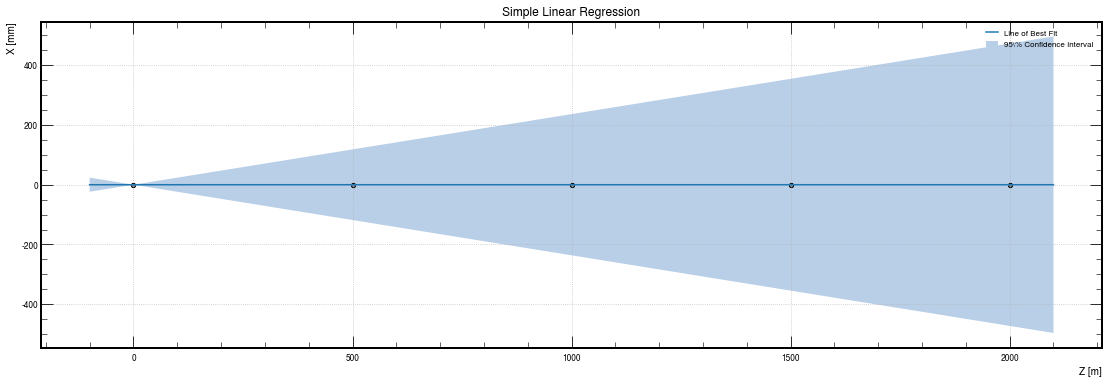

In [42]:
# For interests sake let's have a look at one of the fits
fig = plt.figure(figsize=(19,6))
plt.scatter(z, x, c='gray', marker='o', edgecolors='k', s=18)
# Line of best fit
xlim = plt.xlim()
ylim = plt.ylim()
plt.plot(np.array(xlim), p[1] + p[0] * np.array(xlim), label=f'Line of Best Fit')
# Fit
x_fitted = np.linspace(xlim[0], xlim[1], 100)
y_fitted = np.polyval(p, x_fitted)
# Confidence interval
ci = t_critical * std_err * np.sqrt(1 / n + (x_fitted - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
plt.fill_between(
    x_fitted, y_fitted + ci, y_fitted - ci, facecolor='#b9cfe7', zorder=0,
    label=r'95\% Confidence Interval'
)
# Title and labels
plt.title('Simple Linear Regression')
plt.xlabel('Z [m]')
plt.ylabel('X [mm]')
plt.grid()
# Finished
plt.legend(fontsize=8)
plt.show()

It is unsuprising the confidence interval is so large given that we only have 5 points. Now let's go and find all the gradients using separate linear fits,

In [55]:
# Degree of fitting polynomial 
deg = 1
m1, m2 = [], []

for i in range(df["Dc1HitsVector_x"].shape[0]):
    x1 = df["Dc1HitsVector_x"][i] * np.random.normal(loc=1, scale=100E-3) # Smear these data with our detector resolution
    z1 = df["Dc1HitsVector_z"][i]*0.5*1.E+3
    x2 = df["Dc2HitsVector_x"][i] * np.random.normal(loc=1, scale=100E-3) # Smear these data with our detector resolution
    z2 = df["Dc2HitsVector_z"][i]*0.5*1.E+3
    p = np.polyfit(z1, x1, deg)
    m, c = p[0], p[1]
    m1.append(m)
    p = np.polyfit(z2, x2, deg)
    m, c = p[0], p[1]
    m2.append(m)
m1 = np.array(m1)
m2 = np.array(m2)

In [56]:
# Now find the angle between two straight lines, easy geometry here
dthetas = []
for grad1, grad2 in zip(m1, m2):
    dtheta = np.arctan(np.abs((grad1-grad2)/(1-(grad1*grad2))))
    dthetas.append(dtheta)
# This is clearly a very slow way to do all this but it is spaced out so it is easy to read

In [52]:
def get_pT(dtheta, B_FIELD_STRENGTH=0.5, LENGTH_IN_B_FIELD=2.0):
    return 0.3*B_FIELD_STRENGTH*LENGTH_IN_B_FIELD / dtheta

In [75]:
def gauss(x, mu, sigma, scale):
    return scale*np.exp(-((x-mu)**2)/(sigma**2))

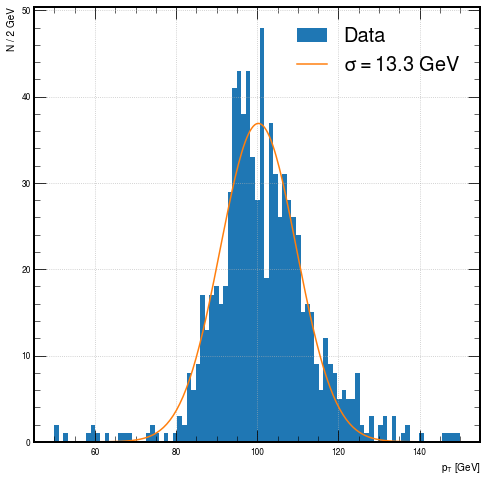

In [89]:
# Calculate and plot a distribution of the calculated pT values
from scipy.optimize import curve_fit
h = np.histogram(get_pT(np.array(dthetas)), bins=np.linspace(50, 150, 90))#
centres = np.array([(h[1][i]+h[1][i+1])/2 for i in range(h[1].shape[0]-1)])
popt, pcov = curve_fit(gauss, centres, h[0], p0=[100, 5, 50])
# above is a *very* crude but it works well enough gives us a rough idea of our resolution

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
hep.histplot(h, ax=ax, label='Data', histtype='fill')
plt.plot(np.linspace(60, 140, 200), gauss(np.linspace(60,140,200), *popt), label=r"$\sigma=13.3$ GeV")
plt.grid()
plt.ylabel('N / 2 GeV')
plt.xlabel(r'$p_T$ [GeV]')
plt.legend(fontsize=20)
plt.show()

In [90]:
# Let's calculate the chi2 of this fit as well to get an idea of how good/bad it is, we can see the distribution isn't really very gaussian
chi2 = np.sum((h[0]-gauss(centres, *popt))**2/(1/np.sqrt(h[0])))
chi2_reduced = chi2 / (h[0].shape[0] - 2) # dof = n(obs) - n(params)
chi2_reduced # ouch...not great

/tmp/ipykernel_4012632/3527655034.py:2: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum((h[0]-gauss(centres, *popt))**2/(1/np.sqrt(h[0])))


67.94761736160858

# Method 2: Global fit
In this method we exploit the fact that for some given momentum (and mass) we know what the curvature should be in the magnetic field. Therefore we know where our particle "should" exit the field given we know where it enters. Hence we can perform a global fit incorporating these facts.